# Retrieve Data from Amazon S3 Cloud 
This example shows how to use astroquery to get the cloud url, retrieve and open the file. 

By:
Susan E. Mullally, Senior Archive Scientist for MAST


In [1]:
from astroquery.mast import Observations
from astropy.io import fits
import boto3

## Use astroquery to search for the observation
I've decided to look for data on TIC25155310, which is WASP-126. In particular I'm going after Sector 2 light curve data.  For simplicity I'm searching directly on the obs_id which I happen to know is formatted like the following: tess2018234235059-s0002-0000000025155310-0121-s. So we can use that to search by sector and tic number and use wild cars for the rest.

In [2]:
sector =2
ticid = 25155310
obs_id_search = "tess*-s%04i-%016i*" % (sector, ticid)

obsTable = Observations.query_criteria(obs_id=obs_id_search)
print(obsTable)

dataproduct_type calib_level obs_collection ...    obsid       objID   
---------------- ----------- -------------- ... ----------- -----------
      timeseries           3           TESS ... 17000045156 17001104290


## Get Exact Product 
We ask for the products that are available and filter down to the light curve file by using productSubGroupDescription = 'LC'

In [9]:
products = Observations.get_product_list(obsTable)
mylc = products[products['productSubGroupDescription'] == 'LC']
print(mylc['obs_id'])

                     obs_id                    
-----------------------------------------------
tess2018234235059-s0002-0000000025155310-0121-s


## Get the location of the data on the AWS S3 Cloud
You use astroquery.Observations 'enable_cloud_dataset()' to have it return the cloud location.

In [10]:
Observations.enable_cloud_dataset()
url = Observations.get_cloud_uris(mylc)
print(url)

INFO: Using the S3 STScI public dataset [astroquery.mast.core]
INFO: See Request Pricing in https://aws.amazon.com/s3/pricing/ for details [astroquery.mast.core]
INFO: If you have not configured boto3, follow the instructions here: https://boto3.readthedocs.io/en/latest/guide/configuration.html [astroquery.mast.core]
['s3://stpubdata/tess/public/tid/s0002/0000/0000/2515/5310/tess2018234235059-s0002-0000000025155310-0121-s_lc.fits']


## Use boto3 to put the data in a bucket
Amazon S3 boto3 creates a bucket for the data.  Then from the bucket we can download our file. 

Notice that the root path on this platform is "/home/jovyan".  I opened a terminal and created a directory called "data" to store our files.

In [11]:
s3 = boto3.resource('s3')
bucket = s3.Bucket('stpubdata')

#Remove the beginning of the url
fits_s3_key = url[0].replace("s3://stpubdata/", "")

#Pick a local location for the file.
file_name = url[0].split('/')[-1]
full_path = "/home/jovyan/data/" + file_name

bucket.download_file(fits_s3_key, full_path, ExtraArgs = {"RequestPayer" : "requester"})

print(full_path)

/home/jovyan/data/tess2018234235059-s0002-0000000025155310-0121-s_lc.fits


## Open the file

In [12]:
fits.info(full_path)

Filename: /home/jovyan/data/tess2018234235059-s0002-0000000025155310-0121-s_lc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      44   ()      
  1  LIGHTCURVE    1 BinTableHDU    167   19737R x 20C   [D, E, J, E, E, E, E, E, E, J, D, E, D, E, D, E, D, E, E, E]   
  2  APERTURE      1 ImageHDU        49   (11, 11)   int32   


Text(0.5, 0, 'Time (BTJD)')

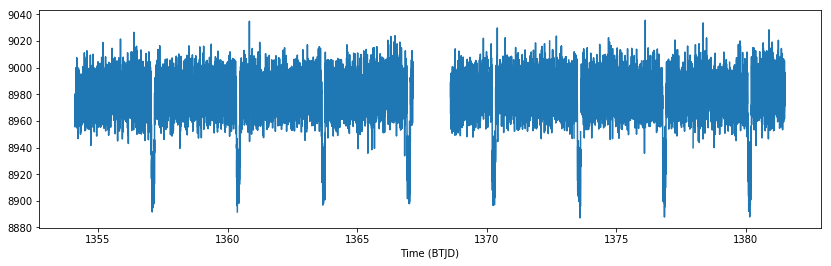

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,4))
data=fits.getdata(full_path)
plt.plot(data['TIME'],data['PDCSAP_FLUX'])
plt.xlabel('Time (BTJD)')

## Delete the file from your system
When you are done you can delete the files from your system. Remember that you do not have unlimited space, so if you are doing something that digs through a lot of data, you might need to remove files as you go along.

In [14]:
import os
os.remove(full_path)